In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/fl_2020/fl_2020.shp")

In [4]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/2020-general-election-rev/")

In [6]:
#Minor processing note: For the FRA file, I replaced ""AJ"" w/ "AJ", so the load works

In [7]:
#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store":
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

### The code below deals with recount votes, not using at this time

The totals of the recount votes are not making sense and the data does not look accurate

In [9]:
# frame = frame[~((frame[0] == "DAD")&(frame[11]=="State Senator")&(frame[12]==' District 37'))]

# li = []
# for i in all_files:
#     if i in ["DAD_PctResults20201103recount.txt"]:
#         ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
#         file_ref = ref+i
#         file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
#         li.append(file_prev)
# frame_recount = pd.concat(li, axis=0, ignore_index=True)
# print(frame_recount.shape)

# frame = pd.concat([frame,frame_recount])

https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [10]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

In [11]:
frame.rename(columns = col_rename_dict, inplace = True)

In [12]:
races_list = races_list = ['President of the United States', 'Representative in Congress',
       'State Representative','State Senator','Retention of Carlos G. Muñiz','Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities']

In [13]:
#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

<ipython-input-13-5edbeda0f2eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
<ipython-input-13-5edbeda0f2eb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)
<ipython-input

In [14]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

<ipython-input-14-46da4f0e8365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
<ipython-input-14-46da4f0e8365>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)


In [15]:
filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])

<ipython-input-15-cc08b28a7227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])


In [16]:
filtered_frame['Candidate Party (abbreviation)'].unique()

array(['REP', 'DEM', 'LPF', 'REF', 'PSL', 'GRE', 'CPF', 'WRI', 'NPA',
       'NOP'], dtype=object)

In [17]:
# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

<ipython-input-17-fe582c8917a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']


In [18]:
# Where it exists, add in the district to the pivot column
filtered_frame["pivot_col"] = np.where(filtered_frame["District"]!=" ",filtered_frame["pivot_col"] + "-" + filtered_frame["District"], filtered_frame["pivot_col"])

<ipython-input-18-d12f4a46ad53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = np.where(filtered_frame["District"]!=" ",filtered_frame["pivot_col"] + "-" + filtered_frame["District"], filtered_frame["pivot_col"])


### Pivot the Data

In [19]:
filtered_frame[filtered_frame["Contest Name"]== "Representative in Congress"]

,County Code (Three-character abbreviation),County Name,Election Number,Election Date,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Total Registered Republicans,Total Registered Democrats,Total Registered All Other Parties,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Candidate Florida Voter Registration System ID Number,DOE Assigned Candidate Number or Retention/Issue Number,Vote Total,mod_col,modified_pre,pct_std,pivot_col
110,OKE,Okeechobee,10866,11/03/2020,2020 General Election,1,1-ABIDING HOPE WORSHIP CENTER,1593,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,929,1,0001,OKE0001,Representative in Congress-Greg Steube-PARTY:R...
111,OKE,Okeechobee,10866,11/03/2020,2020 General Election,2,2-BASINGER COMMUNITY CENTER,849,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,515,2,0002,OKE0002,Representative in Congress-Greg Steube-PARTY:R...
112,OKE,Okeechobee,10866,11/03/2020,2020 General Election,3,3-OAKVIEW BAPTIST CHURCH,2449,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,1527,3,0003,OKE0003,Representative in Congress-Greg Steube-PARTY:R...
113,OKE,Okeechobee,10866,11/03/2020,2020 General Election,4,4-OKEECHOBEE CIVIC CENTER,3021,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,1031,4,0004,OKE0004,Representative in Congress-Greg Steube-PARTY:R...
114,OKE,Okeechobee,10866,11/03/2020,2020 General Election,5,5-FREEDOM RANCH,1567,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,807,5,0005,OKE0005,Representative in Congress-Greg Steube-PARTY:R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551503,GAD,Gadsden,10866,11/03/2020,2020 General Election,21,Pre 21 Green Shade AME Church,566,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,266,21,0021,GAD0021,Representative in Congress-Al Lawson-PARTY:DEM...
551504,GAD,Gadsden,10866,11/03/2020,2020 General Election,22,Pre 22 Second Elizabeth Church,711,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,424,22,0022,GAD0022,Representative in Congress-Al Lawson-PARTY:DEM...
551505,GAD,Gadsden,10866,11/03/2020,2020 General Election,23,Pre 23 New Direction Christian,787,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,397,23,0023,GAD0023,Representative in Congress-Al Lawson-PARTY:DEM...
551506,GAD,Gadsden,10866,11/03/2020,2020 General Election,24,Pre 24 St. Joseph Missionary B,477,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,347,24,0024,GAD0024,Representative in Congress-Al Lawson-PARTY:DEM...


In [20]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())

[0]
[0]
[0]


In [21]:
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

In [27]:
pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

In [28]:
pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

In [29]:
pivoted_2020 = pivoted_2020.fillna(0)

## Look into split precincts

In [30]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [31]:
district_cols = [i for i in pivoted_2020.columns if "Representative" in i or "State Senator" in i]

In [32]:
def get_level_dist(column_name):
    zfill_level = 2
    if "Representative in Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
        zfill_level = 3
    else:
        raise ValueError
    return_val = re.findall("District \S*",column_name) 
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
        dist = dist.zfill(zfill_level)
    else:
        raise ValueError
    return level,dist

In [33]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pivoted_2020.iterrows():
    # print(row)
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            # print(contest)
            precinct_info = get_level_dist(contest)
            # print(precinct_info)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["pct_std"]]=is_split
    precinct_mapping_dict[row["pct_std"]]=precinct_list

## Rename Columns

In [36]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','Total Registered Voters']

In [37]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [38]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    elif "PARTY:LPF" in contest:
        return "L"
    ## Reform -> F
    elif "PARTY:REF" in contest:
        return "O"
    elif "PARTY:PSL" in contest:
        return "S"
    elif "PARTY:GRE" in contest:
        return "G"
    elif "PARTY:CPF" in contest:
        return "C"
    elif "PARTY:WRI" in contest:
        return "O"
    elif "PARTY:NPA" or "PARTY:NOP" in contest:
        return "N"
    else:
        print(contest)
        return ValueError

In [39]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [40]:
races_list = ['President of the United States', 'Representative in Congress',
       'State Representative','State Senator','Retention of Carlos G. Muñiz','Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities']

In [41]:
contest_name_change_dict = {
'Total Registered Voters':'REG_VOTERS',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP':'G20A01NO',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP':'G20A01YES',
'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP':'G20A02NO',
'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP':'G20A02YES',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet':'G20A03NO',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet':'G20A03YES',
'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP':'G20A04NO',
'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP':'G20A04YES',
'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-No for Rejection-PARTY:NOP':'G20A05NO',
'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-Yes for Approval-PARTY:NOP':'G20A05YES',
'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-No for Rejection-PARTY:NOP- Combat-Related Disabilities':'G20A06NO',
'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-Yes for Approval-PARTY:NOP- Combat-Related Disabilities':'G20A06YES',
'President of the United States-Biden / Harris-PARTY:DEM':'G20PREDBID',
'President of the United States-Blankenship / Mohr-PARTY:CPF':'G20PRECBLA',
'President of the United States-De La Fuente / Richardson-PARTY:REF':'G20PREODEL',
'President of the United States-Hawkins / Walker-PARTY:GRE':'G20PREGHAW',
'President of the United States-Jorgensen / Cohen-PARTY:LPF':'G20PRELJOR',
'President of the United States-La Riva / Freeman-PARTY:PSL':'G20PRESLAR',
'President of the United States-Trump / Pence-PARTY:REP':'G20PRERTRU',
'President of the United States-WriteinVotes-PARTY:WRI':'G20PREOWRI',
'Retention of Carlos G. Muñiz-No-PARTY:NOP-Justice of the Supreme Court':'G20SSCNNO',
'Retention of Carlos G. Muñiz-Yes-PARTY:NOP-Justice of the Supreme Court':'G20SSCNYES'}

In [42]:
for contest in pivoted_2020.columns:
    if contest not in keep_names and "Amendment" not in contest and "Carlos G. Mu" not in contest and "President" not in contest:
        # Add in a condition about the 20
        value = "G"+ get_race(contest)+ get_party(contest)+ get_name(contest)
        contest_name_change_dict[contest] = value
    else:
        print("'"+contest+"':'',")


'pct_std':'',
'County Code (Three-character abbreviation)':'',
'County Name':'',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP':'',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP':'',
'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP':'',
'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP':'',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet':'',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet':'',
'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP':'',
'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP':'',
'Amendment No. 5: Limitations on Homestead Property T

In [44]:
for val in contest_name_change_dict.values():
    print(val)
    print(len(val))

REG_VOTERS
10
G20A01NO
8
G20A01YES
9
G20A02NO
8
G20A02YES
9
G20A03NO
8
G20A03YES
9
G20A04NO
8
G20A04YES
9
G20A05NO
8
G20A05YES
9
G20A06NO
8
G20A06YES
9
G20PREDBID
10
G20PRECBLA
10
G20PREODEL
10
G20PREGHAW
10
G20PRELJOR
10
G20PRESLAR
10
G20PRERTRU
10
G20PREOWRI
10
G20SSCNNO
9
G20SSCNYES
10
GCON03DCHR
10
GCON05DLAW
10
GCON15DCOH
10
GCON01NORA
10
GCON20DHAS
10
GCON17DELL
10
GCON13RLUN
10
GCON08RPOS
10
GCON18RMAS
10
GCON19RDON
10
GCON23RSPA
10
GCON26RGIM
10
GCON21NMAL
10
GCON13DCRI
10
GCON24NOLI
10
GCON14RQUI
10
GCON19DBAN
10
GCON06DCUR
10
GCON11DCOT
10
GCON11RWEB
10
GCON09DSOT
10
GCON26DMUC
10
GCON23DSCH
10
GCON04DDEE
10
GCON27DSHA
10
GCON24DWIL
10
GCON05RADL
10
GCON20RMUS
10
GCON17RSTE
10
GCON12RBIL
10
GCON22RPRU
10
GCON08DKEN
10
GCON04RRUT
10
GCON18NMIL
10
GCON03RCAM
10
GCON14DCAS
10
GCON12DWAL
10
GCON21RLOO
10
GCON24RSPI
10
GCON07RVAL
10
GCON21DFRA
10
GCON16DGOO
10
GCON27RSAL
10
GCON01RGAE
10
GCON06RWAL
10
GCON02RDUN
10
GCON18DKEI
10
GCON01DEHR
10
GCON15RFRA
10
GCON07DMUR
10
GCON22DDEU

In [45]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [46]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
#df.to_csv('./cand_dicts/oh_gen_20_st_prec.csv', sep=',')

## Check Statewide Totals

In [48]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [49]:
statewide_totals_check(vest_fl_20,pivoted_2020,data_columns)

***Statewide Totals Check***
G20PRERTRU has a difference of 15.0 votes
	VEST: 5668731 votes
	SOURCES: 5668716.0 votes
G20PREDBID has a difference of 9.0 votes
	VEST: 5297045 votes
	SOURCES: 5297036.0 votes
G20PRELJOR has a difference of 1.0 votes
	VEST: 70324 votes
	SOURCES: 70323.0 votes
G20PREODEL is equal 	VEST / RDH: 5966
G20PRESLAR is equal 	VEST / RDH: 5712
G20PREGHAW is equal 	VEST / RDH: 14721
G20PRECBLA is equal 	VEST / RDH: 3902
G20PREOWRI is equal 	VEST / RDH: 24468


In [50]:
pivoted_2020.columns

Index(['pct_std', 'County Code (Three-character abbreviation)', 'County Name',
       'G20A01NO', 'G20A01YES', 'G20A02NO', 'G20A02YES', 'G20A03NO',
       'G20A03YES', 'G20A04NO',
       ...
       'GSU17DFRE', 'GSU35DJON', 'GSU05DPET', 'GSU31RDON', 'GSU29DPOL',
       'GSU07RHUT', 'GSU15DTOR', 'GSU03OWRI', 'GSU35OWRI', 'GSU07OWRI'],
      dtype='object', length=345)

## Check County-by-County Totals

In [51]:
#Add a county column
pivoted_2020["county"] = pivoted_2020["pct_std"].str[0:3]

In [52]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [53]:
county_totals_check(vest_fl_20,pivoted_2020,data_columns,"county",full_print=False)

#Used the below to check against the official state totals
#vest_fl_20.groupby(["county"]).sum().to_csv("./vest_county_totals.csv")

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	MON has a difference of 10.0 votes
		VEST: 25693 votes
		SOURCES: 25683.0 votes
	SEM has a difference of 5.0 votes
		VEST: 125241 votes
		SOURCES: 125236.0 votes
G20PREDBID contains differences in these counties:
	MON has a difference of 5.0 votes
		VEST: 21881 votes
		SOURCES: 21876.0 votes
	SEM has a difference of 4.0 votes
		VEST: 132528 votes
		SOURCES: 132524.0 votes
G20PRELJOR contains differences in these counties:
	MON has a difference of 1.0 votes
		VEST: 348 votes
		SOURCES: 347.0 votes
G20PREODEL is equal across all counties
G20PRESLAR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREOWRI is equal across all counties


## Filter Columns

In [54]:
keep_columns = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','county']
state_data_columns = [i for i in pivoted_2020.columns if ("GSU" in i)]

state_data_columns.sort()

pivoted_2020_sldl = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GSL" in i)]]
pivoted_2020_st = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if (("G20A" in i) or ("G20PRE" in i) or ("G20SSC" in i))]]
pivoted_2020_sldu = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GSU" in i)]]
pivoted_2020_cong = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GCON" in i)]]

### Precinct-by-Precinct Check

In [55]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020_sldu["pct_std"].value_counts(dropna=False))

VOL0812    1
DIX0010    1
PAL1102    1
ALA0061    1
BAY0044    1
          ..
PAL3102    1
HIL0353    1
DUV0110    1
HER0030    1
BROC028    1
Name: pct_std, Length: 6010, dtype: int64
VOL0812    1
STJ0402    1
OKE0001    1
PAL1340    1
PAL5030    1
          ..
LEO3469    1
JAC0010    1
BRE0417    1
PAL3102    1
DAD0457    1
Name: pct_std, Length: 6014, dtype: int64


In [59]:
data_columns_full = [i for i in pivoted_2020_sldu.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

In [60]:
#Combine results in these two precincts to match VEST
pivoted_2020_sldu =pivoted_2020_sldu.fillna(0)
for i in data_columns_full:
    print(i)
    pivoted_2020_sldu[i] = pivoted_2020_sldu[i].astype(int)
    
    pivoted_2020_sldu.loc[pivoted_2020_sldu["pct_std"]=="CHA54.0",i]+=int(pivoted_2020_sldu.loc[pivoted_2020_sldu["pct_std"]=="CHA54.1",i])

#Check that it works
pivoted_2020_sldu.loc[pivoted_2020_sldu["pct_std"]=="CHA54.0"]

#Remove the precinct that the votes were added from
pivoted_2020_sldu = pivoted_2020_sldu[pivoted_2020_sldu["pct_std"]!="CHA54.1"]

GSU37NROD
GSU39RROD
GSU21DELD
GSU29RNOR
GSU39NALF
GSU19NPAY
GSU25DROB
GSU20RBUR
GSU19DROU
GSU17RMAY
GSU01RBRO
GSU25RHAR
GSU07DHUN
GSU37RGAR
GSU09RBRO
GSU39DFER
GSU05RBRA
GSU09NIAN
GSU21RBOY
GSU23RGRU
GSU37DROD
GSU13RAND
GSU11RADA
GSU01DBUT
GSU23DNOR
GSU20DLEW
GSU13DSTE
GSU03DAUS
GSU31DBER
GSU15RMIN
GSU03RPRE
GSU15NJAM
GSU09DSIG
GSU17NSNY
GSU27DBRO
GSU11DBRA
GSU27RROD
GSU23NKAP
GSU17DFRE
GSU35DJON
GSU05DPET
GSU31RDON
GSU29DPOL
GSU07RHUT
GSU15DTOR
GSU03OWRI
GSU35OWRI
GSU07OWRI


### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

Note: The extra_to_allocate df was created by hand and adjusts votes in Monroe and Seminole counties to match official totals.

In [61]:
extra_to_allocate = pd.read_csv("./raw-from-source/Election_Results/pivot_to_build_allocation.csv")
pivoted_2020_sldu = pd.concat([pivoted_2020_sldu, extra_to_allocate])
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
 'SEM0900',
 'SEM0901',
 'SEM0902',
 'SEM0903',
 'SEM0904',
 'SEM0905',
 'SEM0906',
 'SEM0907',
 'SEM0908',
 'SEM0909',
 'SEM0910',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512',
'MON_DIFF','SEM_DIFF']

In [62]:
allocating_votes = pivoted_2020_sldu[pivoted_2020_sldu["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020_sldu[~pivoted_2020_sldu["pct_std"].isin(to_allocate)]

In [63]:
allocating_votes_id_list = list(pivoted_2020_sldu[pivoted_2020_sldu["pct_std"].isin(to_allocate)]["pct_std"])

In [64]:
allocating_votes.shape

(25, 346)

In [65]:
receiving_votes.shape

(5990, 346)

In [66]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [67]:
#Perform the allocation
pivoted_2020_sldu = allocate_absentee(receiving_votes,allocating_votes,data_columns_full,"county",allocating_to_all_empty_precs=False)

In [68]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020_sldu,how="outer",on="pct_std",indicator=True)
join_attempt_one["_merge"].value_counts()

both          5918
left_only       92
right_only      72
Name: _merge, dtype: int64

In [69]:
# election_vest_id_changes = pd.read_csv("./election_vest_id_changes.csv")
# election_vest_id_changes_dict = dict(zip(election_vest_id_changes["election_ID"],election_vest_id_changes["vest_ID"]))

In [70]:
#Make changes to increase joins
election_vest_id_changes_dict = {'UNI1A & 1B': 'UNI001A', 'UNI2A & 2B': 'UNI002A', 'UNI3A & 3B': 'UNI003A', 'UNI4A & 4C': 'UNI004A', 'UNI5A & 5C': 'UNI005A', 'CHA01.0': 'CHA0001', 'CHA02.0': 'CHA0002', 'CHA03.0': 'CHA0003', 'CHA04.0': 'CHA0004', 'CHA05.0': 'CHA0005', 'CHA06.0': 'CHA0006', 'CHA07.0': 'CHA0007', 'CHA08.0': 'CHA0008', 'CHA09.0': 'CHA0009', 'CHA10.0': 'CHA0010', 'CHA11.0': 'CHA0011', 'CHA12.0': 'CHA0012', 'CHA13.0': 'CHA0013', 'CHA14.0': 'CHA0014', 'CHA15.0': 'CHA0015', 'CHA16.0': 'CHA0016', 'CHA17.0': 'CHA0017', 'CHA18.0': 'CHA0018', 'CHA19.0': 'CHA0019', 'CHA20.0': 'CHA0020', 'CHA21.0': 'CHA0021', 'CHA22.0': 'CHA0022', 'CHA23.0': 'CHA0023', 'CHA24.0': 'CHA0024', 'CHA25.0': 'CHA0025', 'CHA26.0': 'CHA0026', 'CHA27.0': 'CHA0027', 'CHA28.0': 'CHA0028', 'CHA29.0': 'CHA0029', 'CHA30.0': 'CHA0030', 'CHA31.0': 'CHA0031', 'CHA32.0': 'CHA0032', 'CHA33.0': 'CHA0033', 'CHA34.0': 'CHA0034', 'CHA35.0': 'CHA0035', 'CHA36.0': 'CHA0036', 'CHA38.0': 'CHA0038', 'CHA39.0': 'CHA0039', 'CHA41.0': 'CHA0041', 'CHA42.0': 'CHA0042', 'CHA43.0': 'CHA0043', 'CHA44.0': 'CHA0044', 'CHA45.0': 'CHA0045', 'CHA46.0': 'CHA0046', 'CHA47.0': 'CHA0047', 'CHA48.0': 'CHA0048', 'CHA49.0': 'CHA0049', 'CHA52.0': 'CHA0052', 'CHA53.0': 'CHA0053', 'CHA55.0': 'CHA0055', 'CHA56.0': 'CHA0056', 'CHA57.0': 'CHA0057', 'CHA58.0': 'CHA0058', 'CHA60.0': 'CHA0060', 'CHA61.0': 'CHA0061', 'CHA63.0': 'CHA0063', 'CHA64.0': 'CHA0064', 'CHA66.0': 'CHA0066', 'CHA67.0': 'CHA0067', 'CHA68.0': 'CHA0068', 'CHA69.0': 'CHA0069', 'CHA75.0': 'CHA0075', 'CHA76.0': 'CHA0076', 'CHA77.0': 'CHA0077', 'CHA78.0': 'CHA0078', 'CHA80.0': 'CHA0080', 'CHA54.0': 'CHA0054'}

#Implement the changes
pivoted_2020_sldu["pct_std"] = pivoted_2020_sldu["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020_sldu["pct_std"])



## Join Again

In [71]:
pivoted_2020_sldu.drop(['county'],inplace=True,axis=1)

In [72]:
#Join again
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020_sldu,how="outer",on="pct_std",indicator=True,validate="1:1")
join_attempt_two["_merge"].value_counts()

both          5990
left_only       20
right_only       0
Name: _merge, dtype: int64

## Clean Columns

### Add a COUNTYFP column

In [73]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

In [74]:
fl_fips_dict

{'Alachua': '001',
 'Baker': '003',
 'Bay': '005',
 'Bradford': '007',
 'Brevard': '009',
 'Broward': '011',
 'Calhoun': '013',
 'Charlotte': '015',
 'Citrus': '017',
 'Clay': '019',
 'Collier': '021',
 'Columbia': '023',
 'Desoto': '027',
 'Dixie': '029',
 'Duval': '031',
 'Escambia': '033',
 'Flagler': '035',
 'Franklin': '037',
 'Gadsden': '039',
 'Gilchrist': '041',
 'Glades': '043',
 'Gulf': '045',
 'Hamilton': '047',
 'Hardee': '049',
 'Hendry': '051',
 'Hernando': '053',
 'Highlands': '055',
 'Hillsborough': '057',
 'Holmes': '059',
 'Indian River': '061',
 'Jackson': '063',
 'Jefferson': '065',
 'Lafayette': '067',
 'Lake': '069',
 'Lee': '071',
 'Leon': '073',
 'Levy': '075',
 'Liberty': '077',
 'Madison': '079',
 'Manatee': '081',
 'Marion': '083',
 'Martin': '085',
 'Miami-Dade': '086',
 'Monroe': '087',
 'Nassau': '089',
 'Okaloosa': '091',
 'Okeechobee': '093',
 'Orange': '095',
 'Osceola': '097',
 'Palm Beach': '099',
 'Pasco': '101',
 'Pinellas': '103',
 'Polk': '105',
 

In [75]:
join_attempt_two["County Name"] = np.where(join_attempt_two["County Name"].isna(), join_attempt_two["county"], join_attempt_two["County Name"])

In [76]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict).fillna(join_attempt_two["County Name"])

In [77]:
fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
}

In [78]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict_2).fillna(join_attempt_two["COUNTYFP"])

In [79]:
join_attempt_two["COUNTYFP"].unique()

array(['001', '005', '007', '011', '013', '015', '017', '019', '023',
       '027', '029', '035', '037', '039', '041', '043', '049', '051',
       '053', '055', '057', '059', '063', '065', '067', '071', '075',
       '077', '079', '081', '089', '091', '093', '095', '103', '105',
       '107', '113', '115', '117', '111', '119', '121', '123', '125',
       '129', '131', '133', '003', '009', '021', '031', '033', '045',
       '047', '061', '069', '073', '083', '085', '086', '087', '099',
       '109', '127', '101', '097'], dtype=object)

In [81]:
join_attempt_two.drop([i for i in join_attempt_two.columns if "_x" in i], axis = 1, inplace = True)

In [82]:
join_attempt_two.columns = [i.replace("_y","") for i in join_attempt_two.columns]

In [83]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [85]:
join_attempt_two = join_attempt_two[["UNIQUE_ID","COUNTYFP","pct_std",'county','precinct']+state_data_columns+["geometry"]]

In [86]:
for val in state_data_columns:
    join_attempt_two[val] = join_attempt_two[val].fillna(0)
    join_attempt_two[val] = join_attempt_two[val].astype(int)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [87]:
join_attempt_two

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,GSU01DBUT,GSU01RBRO,GSU03DAUS,GSU03OWRI,GSU03RPRE,GSU05DPET,GSU05RBRA,GSU07DHUN,GSU07OWRI,GSU07RHUT,GSU09DSIG,GSU09NIAN,GSU09RBRO,GSU11DBRA,GSU11RADA,GSU13DSTE,GSU13RAND,GSU15DTOR,GSU15NJAM,GSU15RMIN,GSU17DFRE,GSU17NSNY,GSU17RMAY,GSU19DROU,GSU19NPAY,GSU20DLEW,GSU20RBUR,GSU21DELD,GSU21RBOY,GSU23DNOR,GSU23NKAP,GSU23RGRU,GSU25DROB,GSU25RHAR,GSU27DBRO,GSU27RROD,GSU29DPOL,GSU29RNOR,GSU31DBER,GSU31RDON,GSU35DJON,GSU35OWRI,GSU37DROD,GSU37NROD,GSU37RGAR,GSU39DFER,GSU39NALF,GSU39RROD,geometry
0,ALA0001,001,ALA0001,ALA,01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.24245 29.85246 0.00000, -82.24..."
1,ALA0002,001,ALA0002,ALA,02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.41775 29.92248 0.00000, -82.41..."
2,ALA0003,001,ALA0003,ALA,03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.53335 29.84801 0.00000, -82.52..."
3,ALA0004,001,ALA0004,ALA,04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.55700 29.65461 0.00000, -82.55..."
4,ALA0005,001,ALA0005,ALA,05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.34441 29.66672 0.00000, -82.34..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6005,OSC0203,097,OSC0203,OSC,203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,731,36,325,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"MULTIPOLYGON Z (((-81.38822 28.32017 0.00000, ..."
6006,OSC0138,097,OSC0138,OSC,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.44815 28.24601 0.00000, -81.45..."
6007,OSC0353,097,OSC0353,OSC,353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.44066 28.24602 0.00000, -81.44..."
6008,OSC0139,097,OSC0139,OSC,139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.45743 28.32764 0.00000, -81.45..."


## Deal with split precincts

In [88]:
# Load shapefile
fl_sldu_shapefile = gp.read_file("./raw-from-source/District_Shapefiles/cb_2018_12_sldu_500k/cb_2018_12_sldu_500k.shp")

In [89]:
fl_sldu_shapefile = fl_sldu_shapefile.to_crs(vest_fl_20.crs)
fl_sldu_shapefile["SLDUST"] = fl_sldu_shapefile["SLDUST"].str[1:3]

In [90]:
def return_sldu_splits(split_dict):
    for val in split_dict.keys():
        if 'SU' in val:
            return split_dict['SU']

In [91]:
sldu_splits_dict = {i:return_sldu_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_sldu_splits(split_precincts_list[i]) != None }

In [92]:
sldu_splits_dict

{'DAD0430': ['37', '39'],
 'DAD0431': ['37', '39'],
 'DAD0849': ['37', '39'],
 'ORA0110': ['11', '15'],
 'ORA0130': ['11', '15'],
 'ORA0419': ['13', '15'],
 'ORA0616': ['11', '15'],
 'ORA0618': ['11', '15'],
 'ORA0630': ['13', '11']}

In [93]:
def district_splits(cd_list, level, old_name, elections_gdf, shps_gdf, unique_ID_col, district_ID, races_list):
    full_shape = elections_gdf.loc[elections_gdf[unique_ID_col]==old_name]
    for index in range(0,len(cd_list)):
        district = shps_gdf.loc[shps_gdf[district_ID]==cd_list[index]]
        new_prec = gp.overlay(full_shape, district, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging District: ",cd_list[index],"and prec:",old_name,"***")
            print(full_shape)
            ax = full_shape.boundary.plot(figsize=(20,20))
        new_prec = new_prec[list(elections_gdf.columns)]
        for column in new_prec:
            if column in races_list and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec[unique_ID_col]=old_name+"-("+level+"-"+cd_list[index]+")"
        elections_gdf = elections_gdf.append(new_prec)
        elections_gdf.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    elections_gdf = elections_gdf[elections_gdf[unique_ID_col] != old_name]
    elections_gdf.reset_index(drop=True,inplace=True)
    return elections_gdf

In [94]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in join_attempt_two["UNIQUE_ID"]:
    cd_list = []
    if val in sldu_splits_dict.keys() and val not in allocating_votes_id_list:
        print(val, "=>", sldu_splits_dict[val])
        join_attempt_two = district_splits(sldu_splits_dict[val],"SU",val, join_attempt_two, fl_sldu_shapefile, "pct_std", "SLDUST", state_data_columns)
        

ORA0110 => ['11', '15']
ORA0130 => ['11', '15']
ORA0419 => ['13', '15']
ORA0616 => ['11', '15']
ORA0618 => ['11', '15']
ORA0630 => ['13', '11']
DAD0430 => ['37', '39']
DAD0431 => ['37', '39']
DAD0849 => ['37', '39']


## Add in a "SLDU_DIST" column

In [95]:
join_attempt_two["Tot_Votes"] = 0

for race in state_data_columns:
    join_attempt_two["Tot_Votes"] += join_attempt_two[race]

In [96]:
def contains_sldu(dist_list):
    # print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        # print("Call on ", dist_tuple)
        if dist_tuple[0] == "SU":
            #print("Found the SU")
            return dist_tuple[1]

In [97]:
check_list = {i:contains_sldu(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03'), ('SL', '021')]
Call on  ('CON', '03')
Call on  ('SL', '021')
Calling on  [('CON', '03'), ('SL', '021')]
Call on  ('CON', '03')
Call on  ('SL', '021')
Calling on  [('CON', '03'), ('SL', '021')]
Call on  ('CON', '03')
Call on  ('SL', '021')
Calling on  [('CON', '03'), ('SL', '021')]
Call on  ('CON', '03')
Call on  ('SL', '021')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03'), ('SL', '021')]
Call on  ('CON', '03')
Call on  ('SL', '021')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03')]
Call on  ('CON', '03')
Calling on  [('CON', '03'), ('SL', '021')]
Ca

Call on  ('CON', '20')
Call on  ('SL', '092')
Calling on  [('CON', '22'), ('SL', '092')]
Call on  ('CON', '22')
Call on  ('SL', '092')
Calling on  [('CON', '22')]
Call on  ('CON', '22')
Calling on  [('CON', '20'), ('SL', '092')]
Call on  ('CON', '20')
Call on  ('SL', '092')
Calling on  [('CON', '20'), ('SL', '092')]
Call on  ('CON', '20')
Call on  ('SL', '092')
Calling on  [('CON', '22'), ('SL', '092')]
Call on  ('CON', '22')
Call on  ('SL', '092')
Calling on  [('CON', '22'), ('SL', '092')]
Call on  ('CON', '22')
Call on  ('SL', '092')
Calling on  [('CON', '20'), ('CON', '22'), ('SL', '092')]
Call on  ('CON', '20')
Call on  ('CON', '22')
Call on  ('SL', '092')
Calling on  [('CON', '22'), ('SU', '29')]
Call on  ('CON', '22')
Call on  ('SU', '29')
Found the SU
Calling on  [('CON', '22'), ('SU', '29')]
Call on  ('CON', '22')
Call on  ('SU', '29')
Found the SU
Calling on  [('CON', '22')]
Call on  ('CON', '22')
Calling on  [('CON', '22')]
Call on  ('CON', '22')
Calling on  [('CON', '22')]
C

Call on  ('SL', '104')
Calling on  [('CON', '23')]
Call on  ('CON', '23')
Calling on  [('CON', '23'), ('SL', '104')]
Call on  ('CON', '23')
Call on  ('SL', '104')
Calling on  [('CON', '23'), ('SL', '104')]
Call on  ('CON', '23')
Call on  ('SL', '104')
Calling on  [('CON', '23'), ('SL', '104'), ('SU', '35')]
Call on  ('CON', '23')
Call on  ('SL', '104')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '23'), ('SL', '104'), ('SU', '35')]
Call on  ('CON', '23')
Call on  ('SL', '104')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '23'), ('SL', '104'), ('SU', '35')]
Call on  ('CON', '23')
Call on  ('SL', '104')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '23'), ('SL', '104')]
Call on  ('CON', '23')
Call on  ('SL', '104')
Calling on  [('CON', '23'), ('SU', '35')]
Call on  ('CON', '23')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '23'), ('SL', '101'), ('SU', '35')]
Call on  ('CON', '23')
Call on  ('SL', '101')
Call on  ('SU', '35')
Found the SU
Calling

Call on  ('SL', '118')
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '26'), ('SL', '118')]
Call on  ('CON', '26')
Call on  ('SL', '118')
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
Found the SU
Calling on  [('CON', '24'), ('SU', '35')]
Call on  ('CON', '24')
Call on  ('SU', '35')
F

Call on  ('CON', '26')
Call on  ('SL', '118')
Calling on  [('CON', '26'), ('SL', '105')]
Call on  ('CON', '26')
Call on  ('SL', '105')
Calling on  [('CON', '27'), ('SL', '115')]
Call on  ('CON', '27')
Call on  ('SL', '115')
Calling on  [('CON', '26'), ('SL', '119')]
Call on  ('CON', '26')
Call on  ('SL', '119')
Calling on  [('CON', '26'), ('SL', '105')]
Call on  ('CON', '26')
Call on  ('SL', '105')
Calling on  [('CON', '26'), ('SL', '118')]
Call on  ('CON', '26')
Call on  ('SL', '118')
Calling on  [('CON', '26'), ('SL', '119')]
Call on  ('CON', '26')
Call on  ('SL', '119')
Calling on  [('CON', '27'), ('SL', '116')]
Call on  ('CON', '27')
Call on  ('SL', '116')
Calling on  [('CON', '26'), ('SL', '105')]
Call on  ('CON', '26')
Call on  ('SL', '105')
Calling on  [('CON', '26'), ('SL', '119')]
Call on  ('CON', '26')
Call on  ('SL', '119')
Calling on  [('CON', '26'), ('SL', '118')]
Call on  ('CON', '26')
Call on  ('SL', '118')
Calling on  [('CON', '26'), ('SL', '118')]
Call on  ('CON', '26'

Calling on  [('CON', '04'), ('SL', '011')]
Call on  ('CON', '04')
Call on  ('SL', '011')
Calling on  [('CON', '04'), ('SL', '011')]
Call on  ('CON', '04')
Call on  ('SL', '011')
Calling on  [('CON', '04'), ('SL', '011')]
Call on  ('CON', '04')
Call on  ('SL', '011')
Calling on  [('CON', '04'), ('SL', '011')]
Call on  ('CON', '04')
Call on  ('SL', '011')
Calling on  [('CON', '04'), ('SL', '011')]
Call on  ('CON', '04')
Call on  ('SL', '011')
Calling on  [('CON', '05'), ('SL', '015')]
Call on  ('CON', '05')
Call on  ('SL', '015')
Calling on  [('CON', '05'), ('SL', '015')]
Call on  ('CON', '05')
Call on  ('SL', '015')
Calling on  [('CON', '05'), ('SL', '015')]
Call on  ('CON', '05')
Call on  ('SL', '015')
Calling on  [('CON', '04'), ('SL', '015')]
Call on  ('CON', '04')
Call on  ('SL', '015')
Calling on  [('CON', '05'), ('CON', '04')]
Call on  ('CON', '05')
Call on  ('CON', '04')
Calling on  [('CON', '05'), ('SL', '015')]
Call on  ('CON', '05')
Call on  ('SL', '015')
Calling on  [('CON', 

Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '12'), ('SL', '064')]
Call on  ('CON', '12')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064')
Calling on  [('CON', '14'), ('SL', '064')]
Call on  ('CON', '14')
Call on  ('SL', '064'

Call on  ('SL', '033')
Calling on  [('CON', '15'), ('SL', '032')]
Call on  ('CON', '15')
Call on  ('SL', '032')
Calling on  [('CON', '11'), ('SL', '033')]
Call on  ('CON', '11')
Call on  ('SL', '033')
Calling on  [('CON', '11'), ('SL', '033')]
Call on  ('CON', '11')
Call on  ('SL', '033')
Calling on  [('CON', '11'), ('SL', '032')]
Call on  ('CON', '11')
Call on  ('SL', '032')
Calling on  [('CON', '11'), ('SL', '032')]
Call on  ('CON', '11')
Call on  ('SL', '032')
Calling on  [('CON', '06'), ('SL', '031')]
Call on  ('CON', '06')
Call on  ('SL', '031')
Calling on  [('CON', '11'), ('SL', '032')]
Call on  ('CON', '11')
Call on  ('SL', '032')
Calling on  [('CON', '15'), ('SL', '032')]
Call on  ('CON', '15')
Call on  ('SL', '032')
Calling on  [('CON', '15'), ('SL', '032')]
Call on  ('CON', '15')
Call on  ('SL', '032')
Calling on  [('CON', '15'), ('SL', '032')]
Call on  ('CON', '15')
Call on  ('SL', '032')
Calling on  [('CON', '15'), ('SL', '032')]
Call on  ('CON', '15')
Call on  ('SL', '032'

Call on  ('SL', '073')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SL', '073'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SL', '073')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SL', '073'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SL', '073')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SL', '073'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SL', '073')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SL', '073'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SL', '073')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SL', '071'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SL', '071')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SU', '21')]
Call on  ('CON', '16')
Call on  ('SU', '21')
Found the SU
Calling on  [('CON', '16'), ('SL', '071'), ('SL', '0

Call on  ('SL', '047')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '047'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '047')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '047'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '047')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '048'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '048')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '049'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '049')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '049'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '049')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '049'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '049')
Call on  ('SU', '13')
Found the SU
Calling on  [('CON', '07'), ('SL', '049'), ('SU', '13')]
Call on  ('CON', '07')
Call on  ('SL', '049')
Call on  ('

Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', '18'), ('SL', '085')]
Call on  ('CON', '18')
Call on  ('SL', '085')
Calling on  [('CON', 

Calling on  [('CON', '21'), ('SL', '081'), ('SU', '29')]
Call on  ('CON', '21')
Call on  ('SL', '081')
Call on  ('SU', '29')
Found the SU
Calling on  [('CON', '21'), ('SL', '081'), ('SU', '31')]
Call on  ('CON', '21')
Call on  ('SL', '081')
Call on  ('SU', '31')
Found the SU
Calling on  [('CON', '21'), ('SL', '081'), ('SU', '31')]
Call on  ('CON', '21')
Call on  ('SL', '081')
Call on  ('SU', '31')
Found the SU
Calling on  [('CON', '21'), ('SL', '081'), ('SU', '29')]
Call on  ('CON', '21')
Call on  ('SL', '081')
Call on  ('SU', '29')
Found the SU
Calling on  [('CON', '21'), ('SL', '081'), ('SU', '31')]
Call on  ('CON', '21')
Call on  ('SL', '081')
Call on  ('SU', '31')
Found the SU
Calling on  [('CON', '21'), ('SL', '081'), ('SU', '31')]
Call on  ('CON', '21')
Call on  ('SL', '081')
Call on  ('SU', '31')
Found the SU
Calling on  [('CON', '21'), ('SL', '090'), ('SU', '31')]
Call on  ('CON', '21')
Call on  ('SL', '090')
Call on  ('SU', '31')
Found the SU
Calling on  [('CON', '21'), ('SL',

Calling on  [('CON', '12'), ('SL', '038'), ('SU', '20')]
Call on  ('CON', '12')
Call on  ('SL', '038')
Call on  ('SU', '20')
Found the SU
Calling on  [('CON', '12'), ('SL', '038'), ('SU', '20')]
Call on  ('CON', '12')
Call on  ('SL', '038')
Call on  ('SU', '20')
Found the SU
Calling on  [('CON', '12'), ('SL', '036')]
Call on  ('CON', '12')
Call on  ('SL', '036')
Calling on  [('CON', '12'), ('SL', '038'), ('SU', '20')]
Call on  ('CON', '12')
Call on  ('SL', '038')
Call on  ('SU', '20')
Found the SU
Calling on  [('CON', '12'), ('SL', '037')]
Call on  ('CON', '12')
Call on  ('SL', '037')
Calling on  [('CON', '12'), ('SL', '037')]
Call on  ('CON', '12')
Call on  ('SL', '037')
Calling on  [('CON', '12'), ('SL', '038')]
Call on  ('CON', '12')
Call on  ('SL', '038')
Calling on  [('CON', '12'), ('SL', '037')]
Call on  ('CON', '12')
Call on  ('SL', '037')
Calling on  [('CON', '12'), ('SL', '037')]
Call on  ('CON', '12')
Call on  ('SL', '037')
Calling on  [('CON', '12'), ('SL', '037')]
Call on  

Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '039')]
Call on  ('CON', '09')
Call on  ('SL', '039')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09')
Call on  ('SL', '041')
Calling on  [('CON', '09'), ('SL', '041')]
Call on  ('CON', '09'

Calling on  [('CON', '07'), ('SL', '030'), ('SL', '028'), ('SL', '029'), ('SU', '09')]
Call on  ('CON', '07')
Call on  ('SL', '030')
Call on  ('SL', '028')
Call on  ('SL', '029')
Call on  ('SU', '09')
Found the SU
Calling on  [('CON', '07'), ('SL', '030'), ('SL', '029'), ('SU', '09')]
Call on  ('CON', '07')
Call on  ('SL', '030')
Call on  ('SL', '029')
Call on  ('SU', '09')
Found the SU
Calling on  [('CON', '07'), ('SL', '030'), ('SL', '028'), ('SL', '029'), ('SU', '09')]
Call on  ('CON', '07')
Call on  ('SL', '030')
Call on  ('SL', '028')
Call on  ('SL', '029')
Call on  ('SU', '09')
Found the SU
Calling on  [('CON', '07'), ('SL', '028'), ('SL', '030'), ('SL', '029'), ('SU', '09')]
Call on  ('CON', '07')
Call on  ('SL', '028')
Call on  ('SL', '030')
Call on  ('SL', '029')
Call on  ('SU', '09')
Found the SU
Calling on  []
Calling on  [('CON', '04'), ('SL', '017'), ('SU', '07')]
Call on  ('CON', '04')
Call on  ('SL', '017')
Call on  ('SU', '07')
Found the SU
Calling on  [('CON', '04'), (

In [98]:
join_attempt_two["SLDU_DIST"] = join_attempt_two["UNIQUE_ID"].map(check_list).fillna("n/a")

In [99]:
fl_sldu_shapefile["SLDU_DIST"] = fl_sldu_shapefile["SLDUST"]
fl_sldu_shapefile = fl_sldu_shapefile[fl_sldu_shapefile["SLDU_DIST"].isin(list(join_attempt_two["SLDU_DIST"].unique()))]

In [100]:
join_attempt_two["geometry"] = join_attempt_two["geometry"].buffer(0)

In [101]:
filtered_results = join_attempt_two[join_attempt_two["SLDU_DIST"]!="n/a"].dissolve("SLDU_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [102]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 20 precincts for differences of greater than 0.1 km^2

1) For 07 difference in area is 65.3596369217726
2) For 03 difference in area is 274.6211973218716
3) For 20 difference in area is 0.41055752305923127
4) For 09 difference in area is 23.82447286738417
5) For 19 difference in area is 4.9159702411529835
6) For 25 difference in area is 114.89868741936243
7) For 21 difference in area is 32.598071766855284
8) For 13 difference in area is 6.695653659268991
9) For 37 difference in area is 25.288840100098373
10) For 15 difference in area is 13.140618646577712
11) For 35 difference in area is 1.9574309314237308
12) For 23 difference in area is 64.7635320822471
13) For 29 difference in area is 194.68248718275305
14) For 05 difference in area is 111.36247073976223
15) For 27 difference in area is 50.25143694127679
16) For 01 difference in area is 111.02708353644748
17) For 17 difference in area is 8.41737839106811
18) For 31 difference in area is 1.0595274419405671
19) For 39 differe

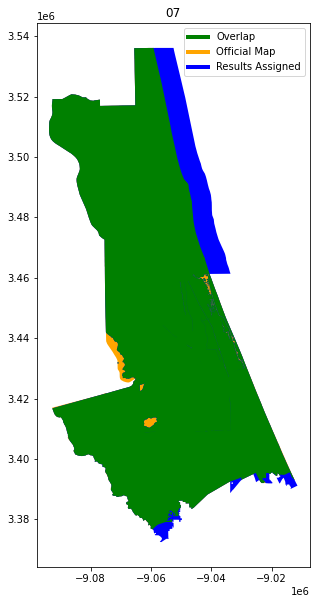

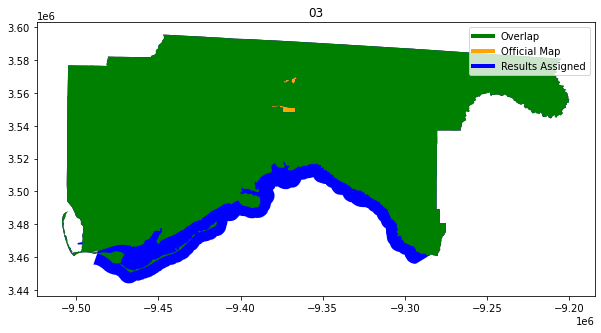

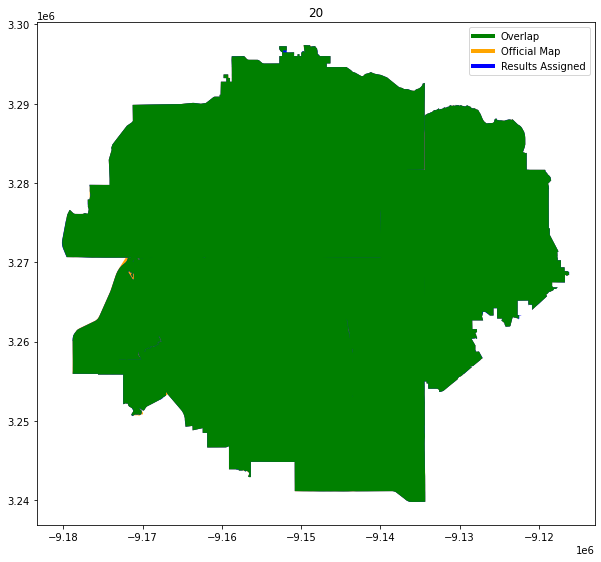

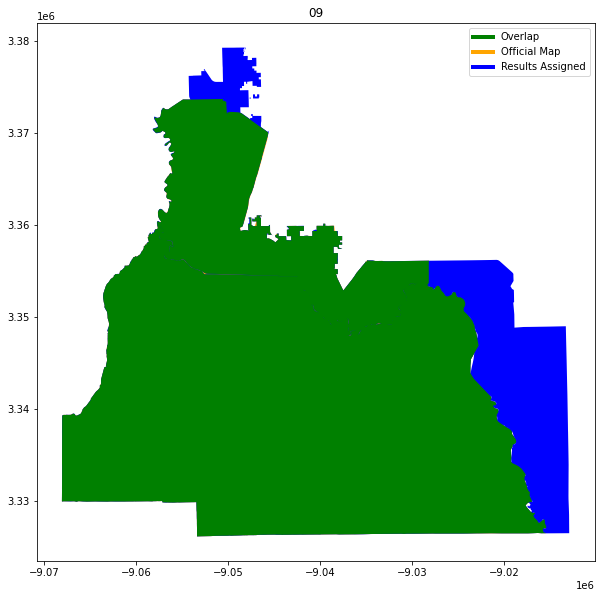

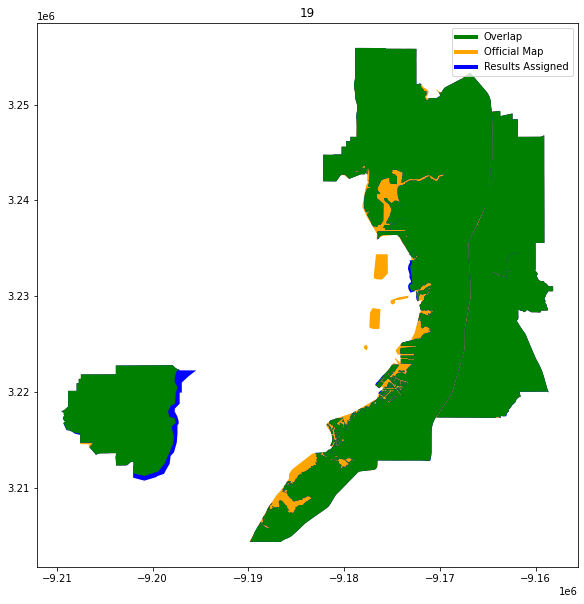

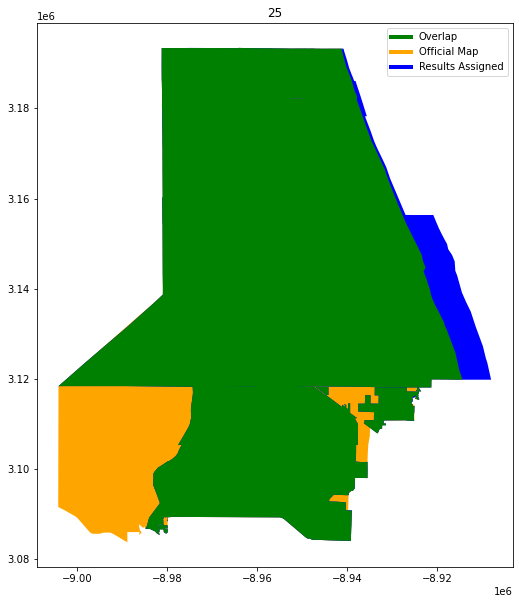

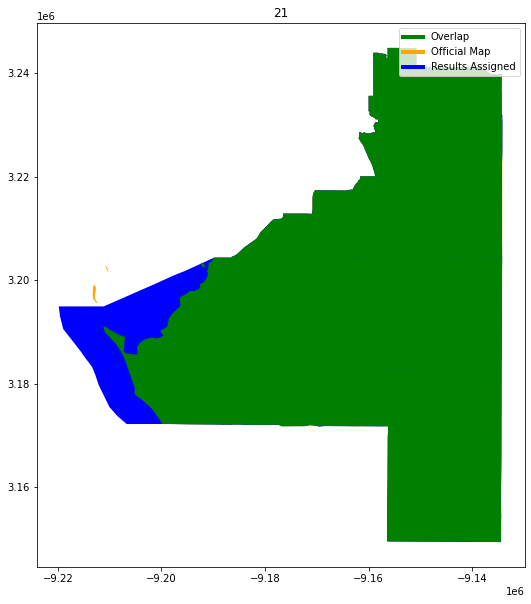

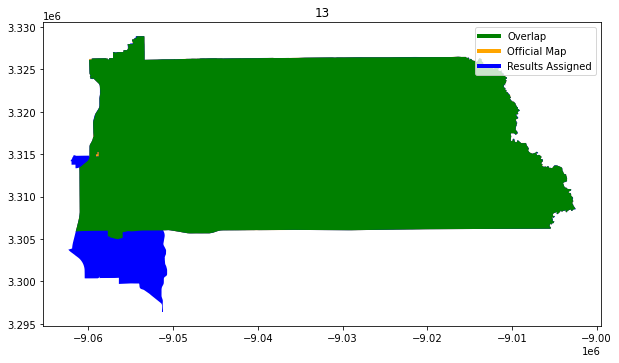

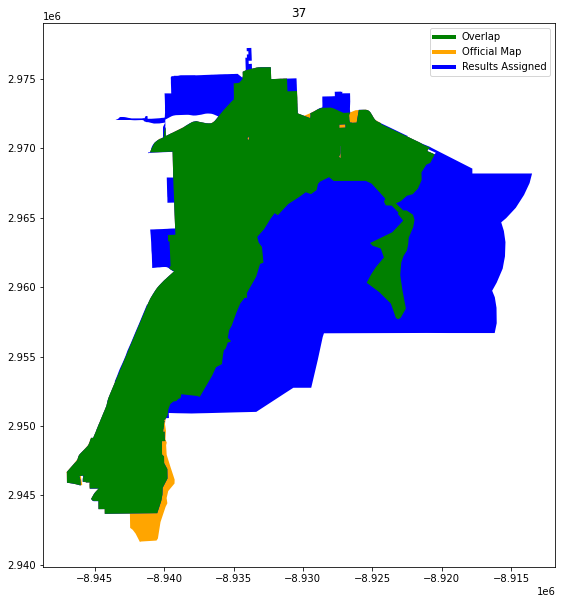

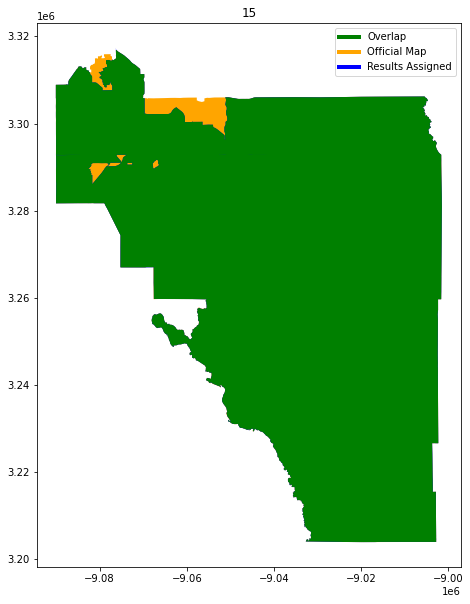

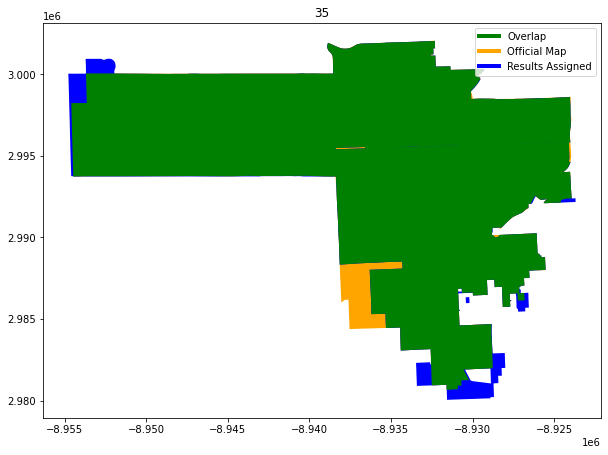

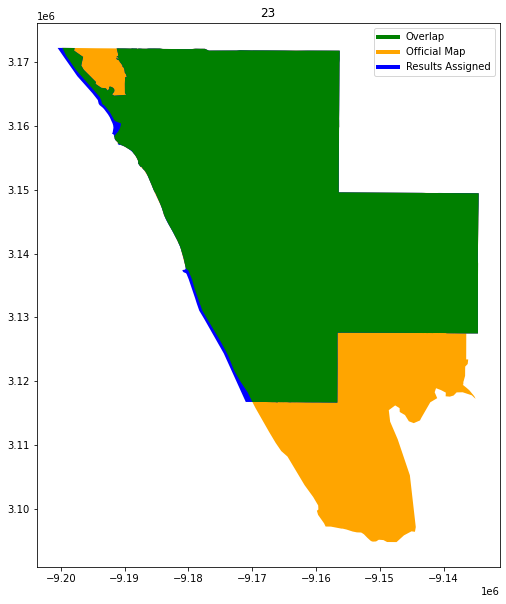

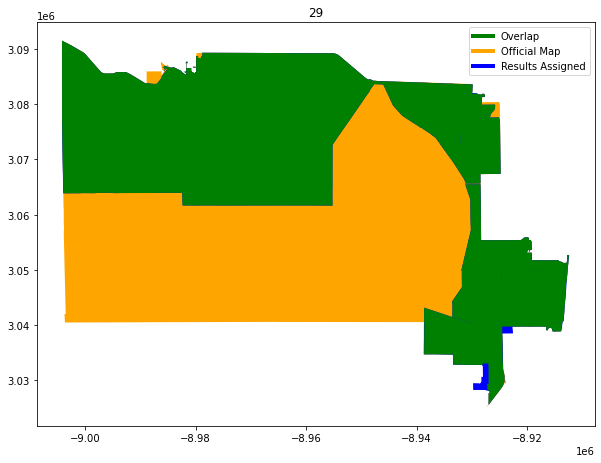

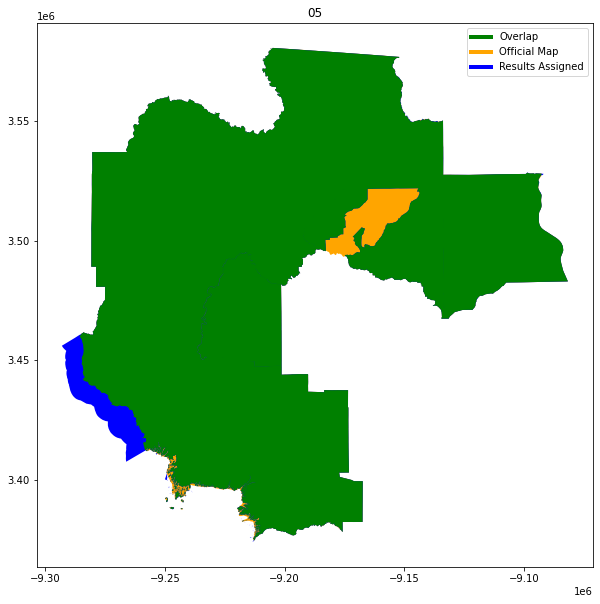

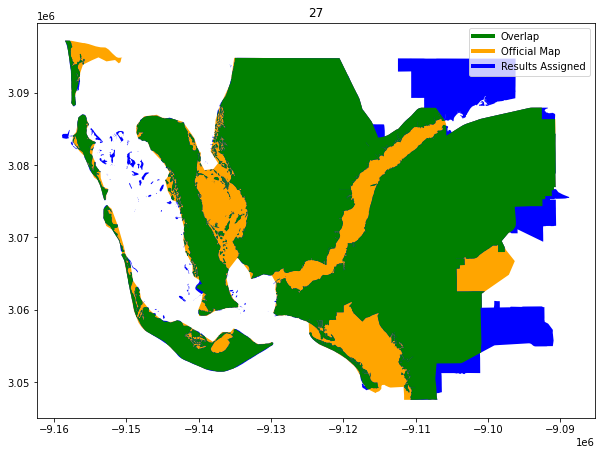

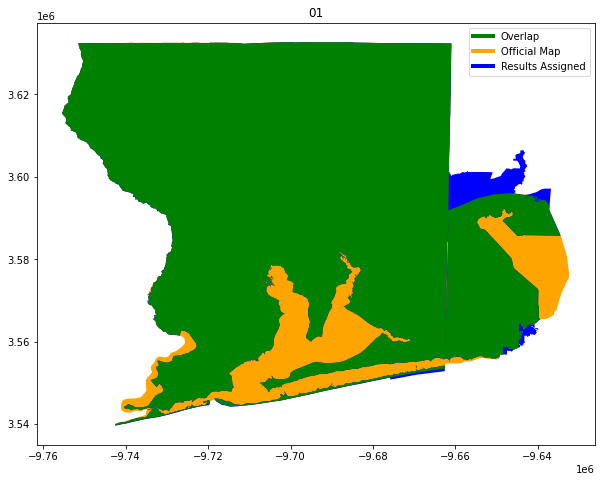

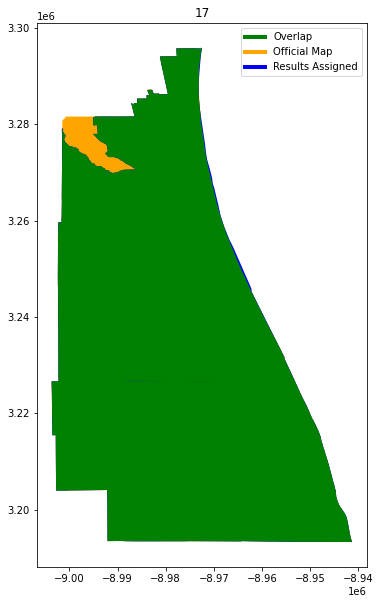

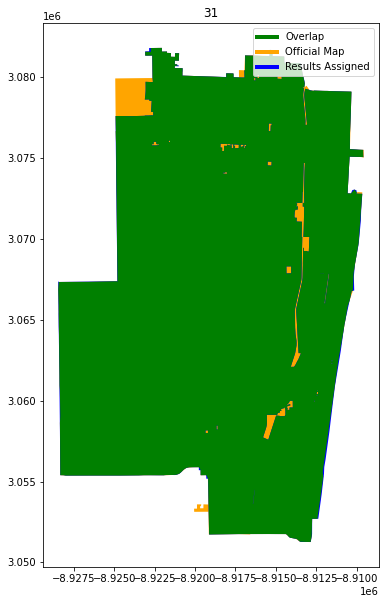

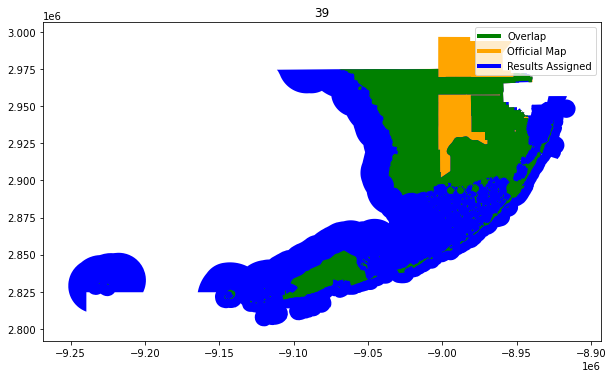

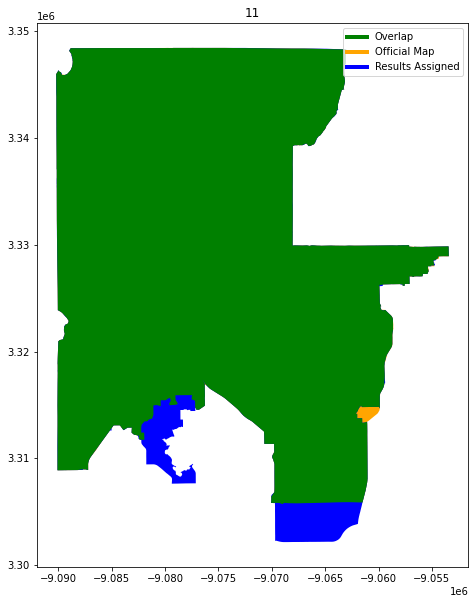

In [103]:
compare_geometries(fl_sldu_shapefile,filtered_results,"Official Map","Results Assigned","SLDU_DIST",area_threshold=.1)

## Election Totals Checks

In [104]:
tot_sum = 0
for val in state_data_columns:
    tot_sum += sum(join_attempt_two[val])
    print(val, sum(join_attempt_two[val]))

GSU01DBUT 98407
GSU01RBRO 185380
GSU03DAUS 137609
GSU03OWRI 10
GSU03RPRE 120176
GSU05DPET 65568
GSU05RBRA 194198
GSU07DHUN 131763
GSU07OWRI 343
GSU07RHUT 212577
GSU09DSIG 133900
GSU09NIAN 5787
GSU09RBRO 141544
GSU11DBRA 147244
GSU11RADA 79224
GSU13DSTE 152769
GSU13RAND 99134
GSU15DTOR 180185
GSU15NJAM 12207
GSU15RMIN 123153
GSU17DFRE 114515
GSU17NSNY 11323
GSU17RMAY 193560
GSU19DROU 174343
GSU19NPAY 79463
GSU20DLEW 116685
GSU20RBUR 141607
GSU21DELD 122480
GSU21RBOY 191673
GSU23DNOR 131491
GSU23NKAP 6696
GSU23RGRU 188126
GSU25DROB 118211
GSU25RHAR 168063
GSU27DBRO 115537
GSU27RROD 176954
GSU29DPOL 156441
GSU29RNOR 124502
GSU31DBER 156495
GSU31RDON 95019
GSU35DJON 188942
GSU35OWRI 5935
GSU37DROD 104588
GSU37NROD 6377
GSU37RGAR 104619
GSU39DFER 95135
GSU39NALF 3639
GSU39RROD 123556


In [105]:
def county_totals_check(source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        print(race)
        diff = source_df.groupby([county_col]).sum()[race]
        for val in diff.index.values.tolist():
            if val in ["MON","SEM"]:
                print("\t"+val + ": "+ str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [106]:
county_totals_check(join_attempt_two,state_data_columns,"county",True)

***Countywide Totals Check***

GSU01DBUT
	MON: 0 votes
	SEM: 0 votes
GSU01RBRO
	MON: 0 votes
	SEM: 0 votes
GSU03DAUS
	MON: 0 votes
	SEM: 0 votes
GSU03OWRI
	MON: 0 votes
	SEM: 0 votes
GSU03RPRE
	MON: 0 votes
	SEM: 0 votes
GSU05DPET
	MON: 0 votes
	SEM: 0 votes
GSU05RBRA
	MON: 0 votes
	SEM: 0 votes
GSU07DHUN
	MON: 0 votes
	SEM: 0 votes
GSU07OWRI
	MON: 0 votes
	SEM: 0 votes
GSU07RHUT
	MON: 0 votes
	SEM: 0 votes
GSU09DSIG
	MON: 0 votes
	SEM: 124056 votes
GSU09NIAN
	MON: 0 votes
	SEM: 4854 votes
GSU09RBRO
	MON: 0 votes
	SEM: 124367 votes
GSU11DBRA
	MON: 0 votes
	SEM: 0 votes
GSU11RADA
	MON: 0 votes
	SEM: 0 votes
GSU13DSTE
	MON: 0 votes
	SEM: 0 votes
GSU13RAND
	MON: 0 votes
	SEM: 0 votes
GSU15DTOR
	MON: 0 votes
	SEM: 0 votes
GSU15NJAM
	MON: 0 votes
	SEM: 0 votes
GSU15RMIN
	MON: 0 votes
	SEM: 0 votes
GSU17DFRE
	MON: 0 votes
	SEM: 0 votes
GSU17NSNY
	MON: 0 votes
	SEM: 0 votes
GSU17RMAY
	MON: 0 votes
	SEM: 0 votes
GSU19DROU
	MON: 0 votes
	SEM: 0 votes
GSU19NPAY
	MON: 0 votes
	SEM: 0 votes
GSU20D

In [107]:
join_attempt_two.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'pct_std', 'county', 'precinct', 'GSU01DBUT',
       'GSU01RBRO', 'GSU03DAUS', 'GSU03OWRI', 'GSU03RPRE', 'GSU05DPET',
       'GSU05RBRA', 'GSU07DHUN', 'GSU07OWRI', 'GSU07RHUT', 'GSU09DSIG',
       'GSU09NIAN', 'GSU09RBRO', 'GSU11DBRA', 'GSU11RADA', 'GSU13DSTE',
       'GSU13RAND', 'GSU15DTOR', 'GSU15NJAM', 'GSU15RMIN', 'GSU17DFRE',
       'GSU17NSNY', 'GSU17RMAY', 'GSU19DROU', 'GSU19NPAY', 'GSU20DLEW',
       'GSU20RBUR', 'GSU21DELD', 'GSU21RBOY', 'GSU23DNOR', 'GSU23NKAP',
       'GSU23RGRU', 'GSU25DROB', 'GSU25RHAR', 'GSU27DBRO', 'GSU27RROD',
       'GSU29DPOL', 'GSU29RNOR', 'GSU31DBER', 'GSU31RDON', 'GSU35DJON',
       'GSU35OWRI', 'GSU37DROD', 'GSU37NROD', 'GSU37RGAR', 'GSU39DFER',
       'GSU39NALF', 'GSU39RROD', 'geometry', 'Tot_Votes', 'SLDU_DIST'],
      dtype='object')

In [108]:
join_attempt_two = join_attempt_two[['UNIQUE_ID', 'COUNTYFP', 'pct_std', 'county', 'precinct', 
       'SLDU_DIST', 'GSU01DBUT',
       'GSU01RBRO', 'GSU03DAUS', 'GSU03OWRI', 'GSU03RPRE', 'GSU05DPET',
       'GSU05RBRA', 'GSU07DHUN', 'GSU07OWRI', 'GSU07RHUT', 'GSU09DSIG',
       'GSU09NIAN', 'GSU09RBRO', 'GSU11DBRA', 'GSU11RADA', 'GSU13DSTE',
       'GSU13RAND', 'GSU15DTOR', 'GSU15NJAM', 'GSU15RMIN', 'GSU17DFRE',
       'GSU17NSNY', 'GSU17RMAY', 'GSU19DROU', 'GSU19NPAY', 'GSU20DLEW',
       'GSU20RBUR', 'GSU21DELD', 'GSU21RBOY', 'GSU23DNOR', 'GSU23NKAP',
       'GSU23RGRU', 'GSU25DROB', 'GSU25RHAR', 'GSU27DBRO', 'GSU27RROD',
       'GSU29DPOL', 'GSU29RNOR', 'GSU31DBER', 'GSU31RDON', 'GSU35DJON',
       'GSU35OWRI', 'GSU37DROD', 'GSU37NROD', 'GSU37RGAR', 'GSU39DFER',
       'GSU39NALF', 'GSU39RROD', 'geometry' ]]

## Export File

In [109]:
if not os.path.exists('./fl_gen_20_prec/'):
    os.mkdir('./fl_gen_20_prec/')

join_attempt_two.to_file('./fl_gen_20_prec/fl_gen_20_sldu_prec.shp')